In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Input, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from sklearn import model_selection
import re

In [3]:
train_data = pd.read_json('train_meta_data.json')
test_data = pd.read_json('test_meta_data.json')

X_train = train_data.drop(columns=['Title', 'Budget', 'Status', 'Released', 'Language', 'Director', 'Actors'])
y_train = train_data['Status']
X_test = test_data.drop(columns=['Title', 'Budget', 'Status', 'Released', 'Language', 'Director', 'Actors'])
y_test = test_data['Status']

def preprocess_text(sen):
    sentence = re.sub(r'[^\w]', ' ', sen)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

In [4]:
token = Tokenizer()
token.fit_on_texts(X_train['Awards'])
max_length_awards = max([len(s) for s in X_train['Awards']])

train_awards_sequences = token.texts_to_sequences(X_train['Awards'])
train_awards_padded = pad_sequences(train_awards_sequences, maxlen=max_length_awards)
awards_vocab_size = len(token.word_index)+1

test_awards_sequences = token.texts_to_sequences(X_test['Awards'])
test_awards_padded = pad_sequences(test_awards_sequences, maxlen=max_length_awards)

input_awards = Input(shape=(max_length_awards,))
embedding_layer = Embedding(awards_vocab_size, max_length_awards)(input_awards)
# LSTM_Layer_4 =LSTM(64, dropout=0.5)(embedding_layer)
flatten = Flatten()(embedding_layer)
dence_Layer_3 = Dense(8, activation='relu',kernel_regularizer=regularizers.l2(0.01))(flatten)

In [5]:
X_train_genre = []
data = list(X_train["Genre"])

for sen in data:
    X_train_genre.append(preprocess_text(sen))

X_test_genre = []
data = list(X_test["Genre"])

for sen in data:
    X_test_genre.append(preprocess_text(sen))

token.fit_on_texts(X_train_genre)
max_length_genre = max([len(s) for s in X_train_genre])

train_genre_sequences = token.texts_to_sequences(X_train_genre)
train_genre_padded = pad_sequences(train_genre_sequences, maxlen=max_length_genre)
genre_vocab_size = len(token.word_index)+1

test_genre_sequences = token.texts_to_sequences(X_test_genre)
test_genre_padded = pad_sequences(test_genre_sequences, maxlen=max_length_genre)

input_genre = Input(shape=(max_length_genre,))
embedding_layer = Embedding(genre_vocab_size, max_length_genre)(input_genre)
# LSTM_Layer_5 =LSTM(64, dropout=0.5)(embedding_layer)
flatten = Flatten()(embedding_layer)
dence_Layer_4 = Dense(8, activation='relu',kernel_regularizer=regularizers.l2(1e-6))(flatten)

In [6]:
X_train_rating = X_train['imdbRating']
X_train_rating=X_train_rating.astype(str)
token.fit_on_texts(X_train_rating)
max_length_rating = max([len(s) for s in X_train_rating])

train_rating_sequences = token.texts_to_sequences(X_train_rating)
train_rating_padded = pad_sequences(train_rating_sequences, maxlen=max_length_rating)
print(train_rating_padded)
rating_vocab_size = len(token.word_index)+1

X_test_rating = X_test['imdbRating']
X_test_rating=X_test_rating.astype(str)
test_rating_sequences = token.texts_to_sequences(X_test_rating)
test_rating_padded = pad_sequences(test_rating_sequences, maxlen=max_length_rating)

input_rating = Input(shape=(max_length_rating,))
dense_layer_5 = Dense(10, activation='relu', kernel_regularizer=regularizers.l2(1e-6))(input_rating)
dense_layer_7 = Dense(20, activation='relu', kernel_regularizer=regularizers.l2(1e-6))(dense_layer_5)
dense_layer_6 = Dense(10, activation='relu', kernel_regularizer=regularizers.l2(1e-6))(dense_layer_7)

[[ 0 21 13]
 [ 0  6  6]
 [ 0  6 21]
 ...
 [ 0  7 31]
 [ 0  2 10]
 [ 0  2  7]]


In [7]:
from tensorflow.python.keras.callbacks import EarlyStopping

# callback = EarlyStopping(monitor='val_loss')
concat_layer = Concatenate()([dence_Layer_3, dence_Layer_4, dense_layer_6])
dense_layer_3 = Dense(10, activation='relu',kernel_regularizer=regularizers.l2(1e-6))(concat_layer)
output = Dense(1, activation='sigmoid')(dense_layer_3)
model = Model(inputs=[input_awards, input_genre, input_rating], outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 68)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 57)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 68, 68)       9520        input_1[0][0]                    
______________________________________________________________________________________________

In [8]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics = ['accuracy'], loss_weights=[1.0, 0.2])

In [9]:
history = model.fit([train_awards_padded, 
                     train_genre_padded, train_rating_padded], y_train, epochs=60, batch_size=20,
                     validation_data= ([test_awards_padded, 
                     test_genre_padded, test_rating_padded], y_test))

Epoch 1/60
22/22 [==============================] - 0s 18ms/step - loss: 0.6968 - accuracy: 0.7355 - val_loss: 0.7085 - val_accuracy: 0.6667
Epoch 2/60
22/22 [==============================] - 0s 5ms/step - loss: 0.6014 - accuracy: 0.7355 - val_loss: 0.6726 - val_accuracy: 0.6667
Epoch 3/60
22/22 [==============================] - 0s 5ms/step - loss: 0.5754 - accuracy: 0.7355 - val_loss: 0.6627 - val_accuracy: 0.6667
Epoch 4/60
22/22 [==============================] - 0s 5ms/step - loss: 0.5634 - accuracy: 0.7378 - val_loss: 0.6345 - val_accuracy: 0.6667
Epoch 5/60
22/22 [==============================] - 0s 4ms/step - loss: 0.5465 - accuracy: 0.7425 - val_loss: 0.6362 - val_accuracy: 0.6533
Epoch 6/60
22/22 [==============================] - 0s 5ms/step - loss: 0.5278 - accuracy: 0.7541 - val_loss: 0.6231 - val_accuracy: 0.6933
Epoch 7/60
22/22 [==============================] - 0s 5ms/step - loss: 0.5150 - accuracy: 0.7564 - val_loss: 0.6419 - val_accuracy: 0.6933
Epoch 8/60
22/22 [=

22/22 [==============================] - 0s 5ms/step - loss: 0.2314 - accuracy: 0.9211 - val_loss: 1.0825 - val_accuracy: 0.6533
Epoch 60/60
22/22 [==============================] - 0s 4ms/step - loss: 0.2368 - accuracy: 0.9211 - val_loss: 1.0892 - val_accuracy: 0.6667


In [10]:
score = model.evaluate(x=[test_awards_padded, 
                     test_genre_padded, test_rating_padded], y=y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

3/3 [==============================] - 0s 1ms/step - loss: 1.0892 - accuracy: 0.6667
Test Score: 1.0891914367675781
Test Accuracy: 0.6666666865348816


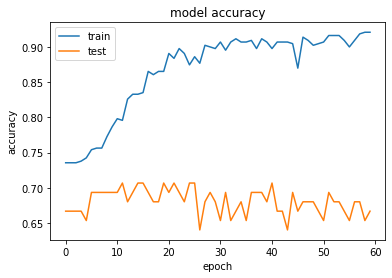

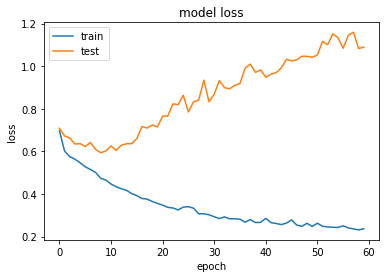

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [12]:
from sklearn.metrics import f1_score

x=[test_awards_padded, test_genre_padded, test_rating_padded]
y_pred = model.predict(x)

m = tf.keras.metrics.BinaryAccuracy()
m.update_state(y_test, y_pred, sample_weight=None)
print('Accuracy %s' % m.result().numpy())

m = tf.keras.metrics.Precision()
m.update_state(y_test, y_pred, sample_weight=None)
print('Precission %s' % m.result().numpy())

m = tf.keras.metrics.Recall()
m.update_state(y_test, y_pred, sample_weight=None)
print('Recall %s' % m.result().numpy())

yhat_probs = model.predict(x, verbose=0)
# predict crisp classes for test set
yhat_classes = np.argmax(yhat_probs,axis=1)

f1 = f1_score(y_test, yhat_classes, average = 'weighted')
print('F1 score: %f' % f1)

Accuracy 0.6666667
Precission 0.5
Recall 0.36
F1 score: 0.533333
